<a href="https://colab.research.google.com/github/NigarRahimli/Branches/blob/main/cs918_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define dataset path (update this if needed)
dataset_path = "/content/semeval-tweets.tar.bz2"

# Create a directory to store extracted files
extract_path = "/content/semeval_tweets"
os.makedirs(extract_path, exist_ok=True)

# Extract files
!tar -xvjf "$dataset_path" -C "$extract_path"

# List extracted files
os.listdir(extract_path)


semeval-tweets/
semeval-tweets/twitter-training-data.txt
semeval-tweets/twitter-dev-data.txt
semeval-tweets/twitter-test3.txt
semeval-tweets/twitter-test2.txt
semeval-tweets/twitter-test1.txt


['semeval-tweets']

##Load Training, Dev, and Test Sets

In [ ]:
import pandas as pd

# File paths
train_file = "/content/semeval_tweets/semeval-tweets/twitter-training-data.txt"
dev_file = "/content/semeval_tweets/semeval-tweets/twitter-dev-data.txt"

# Load datasets
df_train = pd.read_csv(train_file, delimiter="\t", names=["tweet_id", "sentiment", "text"])
df_dev = pd.read_csv(dev_file, delimiter="\t", names=["tweet_id", "sentiment", "text"])

# Display first few rows
df_train.head()


,tweet_id,sentiment,text
0,335104872099066692,positive,Felt privileged to play Foo Fighters songs on ...
1,796528524030124618,positive,@AaqibAfzaal Pakistan may be an Islamic countr...
2,760964834217238632,positive,Happy Birthday to the coolest golfer in Bali! ...
3,147713180324524046,negative,@SimpplyA TMILLS is going to Tucson! But the 2...
4,732302280474120023,negative,Hmmmmm where are the #BlackLivesMatter when ma...


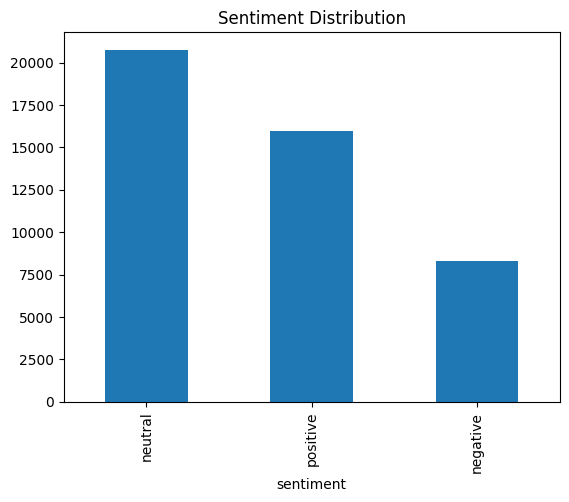

In [ ]:
df_train["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution");


In [ ]:
print("Positive:", df_train[df_train["sentiment"] == "positive"].sample(1)["text"].values[0])
print("Negative:", df_train[df_train["sentiment"] == "negative"].sample(1)["text"].values[0])
print("Neutral:", df_train[df_train["sentiment"] == "neutral"].sample(1)["text"].values[0])


Positive: Interested in @BeatrixPotter &amp; #AlisonUttley? I'll be talking about both this Saturday in Chelsea. @_steph_allen_ https://t.co/etg9phExMV
Negative: The problem with bad leaders (dictators ) is that they always have mentees who will continue where they stopped( Ch… https://t.co/fuPPW47VTs
Neutral: @fuhkiee Hello Flora. This is Patti on behalf of Ira. May I confirm if you already received an e-mail from Globe?


## Build Sentiment Classifiers

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df_train["text"])
X_dev = vectorizer.transform(df_dev["text"])

# Train SVM
svm = SVC(kernel="linear")
svm.fit(X_train, df_train["sentiment"])
svm_preds = svm.predict(X_dev)

# Evaluate SVM
print("SVM F1 Score:", f1_score(df_dev["sentiment"], svm_preds, average="macro"))


SVM F1 Score: 0.6307681409654832


## Evaluate & Compare Classifiers

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_dev["sentiment"], svm_preds))


              precision    recall  f1-score   support

    negative       0.64      0.44      0.53       378
     neutral       0.62      0.78      0.69       919
    positive       0.74      0.62      0.68       703

    accuracy                           0.66      2000
   macro avg       0.67      0.61      0.63      2000
weighted avg       0.67      0.66      0.65      2000



# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a Jupyter notebook for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

#### Import necessary packages
You may import more packages here.

In [ ]:
# Import necessary packages
import re
from os.path import join
import numpy as np

In [ ]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

In [ ]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [ ]:
# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

for dataset in ['twitter-training-data.txt'] + testsets:
    data[dataset] = []
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []

    # write code to read in the datasets here

#### Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over all 5 test sets (2 of them are not provided to you).

In [ ]:
# Buid traditional sentiment classifiers. An example classifier name 'svm' is given
# in the code below. You should replace the other two classifier names
# with your own choices. For features used for classifier training,
# the 'bow' feature is given in the code. But you could also explore the
# use of other features.
for classifier in ['svm', '<classifier-2-name>', '<classifier-3-name>']:
    for features in ['bow', '<feature-2-name>']:
        # Skeleton: Creation and training of the classifiers
        if classifier == 'svm':
            # write the svm classifier here
            print('Training ' + classifier)
        elif classifier == '<classifier-2-name>':
            # write the classifier 2 here
            print('Training ' + classifier)
        elif classifier == '<classifier-3-name>':
            # write the classifier 3 here
            print('Training ' + classifier)
        elif classifier == 'LSTM':
            # write the LSTM classifier here
            if features == 'bow':
                continue
            print('Training ' + classifier)
        else:
            print('Unknown classifier name' + classifier)
            continue

        # Predition performance of the classifiers
        for testset in testsets:
            id_preds = {}
            # write the prediction and evaluation code here

            testset_name = testset
            testset_path = join('/content/semeval_tweets/semeval-tweets', testset_name)
            evaluate(id_preds, testset_path, features + '-' + classifier)

Training svm
/content/semeval_tweets/semeval-tweets/twitter-test1.txt (bow-svm): 0.000
/content/semeval_tweets/semeval-tweets/twitter-test2.txt (bow-svm): 0.000
/content/semeval_tweets/semeval-tweets/twitter-test3.txt (bow-svm): 0.000
Training svm
/content/semeval_tweets/semeval-tweets/twitter-test1.txt (<feature-2-name>-svm): 0.000
/content/semeval_tweets/semeval-tweets/twitter-test2.txt (<feature-2-name>-svm): 0.000
/content/semeval_tweets/semeval-tweets/twitter-test3.txt (<feature-2-name>-svm): 0.000
Training <classifier-2-name>
/content/semeval_tweets/semeval-tweets/twitter-test1.txt (bow-<classifier-2-name>): 0.000
/content/semeval_tweets/semeval-tweets/twitter-test2.txt (bow-<classifier-2-name>): 0.000
/content/semeval_tweets/semeval-tweets/twitter-test3.txt (bow-<classifier-2-name>): 0.000
Training <classifier-2-name>
/content/semeval_tweets/semeval-tweets/twitter-test1.txt (<feature-2-name>-<classifier-2-name>): 0.000
/content/semeval_tweets/semeval-tweets/twitter-test2.txt (<f